## Начало работы
+ Загрузка пакетов и библиотек
+ Создание спарк сессии

In [1]:
!pip install nltk
!pip install pymorphy2
!pip install pyldavis

In [2]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import pyspark.sql.functions as F
import numpy as np
import time

from gensim.models import Word2Vec
from pyspark.ml.feature import HashingTF, IDF, Word2Vec, CountVectorizer
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from sklearn.pipeline import Pipeline
from pyspark.ml.linalg import DenseVector
from sklearn.cluster import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import nltk
nltk.download('stopwords')

spark = SparkSession.builder.master ('local[*]').getOrCreate()
sc = spark.sparkContext

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
spark: SparkSession = SparkSession.builder \
.master("local[*]") \
.appName("Example") \
.config("spark.some.config.option","some-value") \
.getOrCreate()

In [5]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

## Чтение файла

In [6]:
#прочитать данные из файла csv
df = spark.read.option(key="header" , value="true").csv("parsed_data.csv")
df.show()
df.printSchema()

+--------------------+--------------------+
|                 url|             content|
+--------------------+--------------------+
|  https://0-100km.ru|                NULL|
|   https://0-chan.ru|анонимная имиджбо...|
|     https://0-12.ru|                NULL|
|     https://0--5.ru|Видионаблюдение М...|
|    https://0-0-1.ru|Главная Корпорати...|
|   https://0-base.ru|Без названия Без ...|
|    https://0-nds.ru|Закладки Мед в За...|
|    https://0-ede.ru|О еде Рецепты блю...|
|   https://0--0-0.ru|Автомобильный пор...|
|      https://0-d.ru|Приветствуем Сайт...|
|     https://0-71.ru|                NULL|
|     https://0-34.ru|Главная страница ...|
|     https://0-78.ru|                NULL|
|     https://0-99.ru|Красивый домен эт...|
|      https://0-q.ru|                NULL|
|    https://0-7-7.ru|Заливка смола в Р...|
|    https://0-7-8.ru|занято заходите п...|
|  https://0-cenka.ru|ЦЕНКА РУ професси...|
|https://0-posredn...|                NULL|
|     https://0-36.ru|Погрузчики

In [8]:
print(f'количество строк {df.count()}')

количество строк 11375


In [7]:
#Удалить NULL
data=df.na.drop()
print(f'количество строк {data.count()}')
#data.show()

количество строк 9919


## Препроцессинг: 
+ очистка данных от некорректных символов
+ токенизация
+ нормализация
+ удаление стоп-слов.

In [8]:
#Удалим некорректные символы, сохраним в столбце cleaned
from pyspark.sql.functions import regexp_replace
start = time.time()

pattern_punct = '[!@"“’«»#$%&\'()*+,—/:;<=>?^_`{|}~\[\]]'
data = data.withColumn('cleaned', regexp_replace('content', pattern_punct, ''))
print(f'Количество строк {data.count()}')

end = time.time()
print(f'Общее время выполнения: {end - start}')

Количество строк 9919
Общее время выполнения: 10.570407629013062


In [9]:
#Токенизируем текст - делим на слова
from pyspark.ml.feature import RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="cleaned", outputCol="tokens", pattern=r"\s+")
data = regexTokenizer.transform(data)


In [10]:
df2 = data.select(col("tokens"))


In [11]:
def pymorphy2_311_hotfix():
    from inspect import getfullargspec
    from pymorphy2.units.base import BaseAnalyzerUnit

    def _get_param_names_311(klass):
        if klass.__init__ is object.__init__:
            return []
        args = getfullargspec(klass.__init__).args
        return sorted(args[1:])

    setattr(BaseAnalyzerUnit, '_get_param_names', _get_param_names_311)
 

In [12]:
import pymorphy2
from nltk.corpus import stopwords

ru_stopwords = set(stopwords.words('russian'))
my_stopwords = {'это', 'руб', 'вот', 'что','всё','м', 'г', 'р'}
all_stopwords = ru_stopwords.union(my_stopwords)

#Функция нормализации слов
def preprocess(tokens):
    pymorphy2_311_hotfix()
    morph = pymorphy2.MorphAnalyzer()
    return [morph.normal_forms(word)[0]
            for word in tokens
                if (word not in all_stopwords)]

In [13]:
from pyspark.sql.types import ArrayType, StringType
preprocess_udf = F.udf(preprocess, ArrayType(StringType()))
df2 = df2.withColumn('finished', preprocess_udf('tokens'))\
    .select(col("finished"))


In [16]:
df2.printSchema()
df2.show()


root
 |-- finished: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+
|            finished|
+--------------------+
|[анонимный, имидж...|
|[видионаблюдение,...|
|[главный, корпора...|
|[название, назван...|
|[закладка, мёд, з...|
|[еда, рецепт, блю...|
|[автомобильный, п...|
|[приветствовать, ...|
|[главный, страниц...|
|[красивый, домен,...|
|[заливка, смола, ...|
|[занятый, заходит...|
|[ценка, ру, профе...|
|[погрузчик, вилоч...|
|[ремонт, ремонт, ...|
|[банкротство, физ...|
|[добромиг, подвес...|
|[вход, система, л...|
|[вебинар, дистанц...|
|[домен, продавать...|
+--------------------+
only showing top 20 rows



In [14]:
# Для теста возьмем 10 строк из датасета
df3=df2.limit(10)
df3.printSchema()

root
 |-- finished: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Локальное сохранение файла в формате CSV

mode="overwrite" - если файл существует, он будет перезаписан.


In [17]:
#from pyspark.sql import functions as F
start = time.time()
# Объединяем массив строк в одну строку, разделенную ;
df_content2 = df3.withColumn("finished_str", F.concat_ws(";", "finished"))

# Сохраняем DataFrame в CSV с использованием табуляции в качестве разделителя
df_content2.select("finished_str").write.option("delimiter", ";").csv("Content_parsed.csv", header=True, mode="overwrite")

end = time.time()
print(f'Общее время выполнения: {end - start}')

Общее время выполнения: 1108.2173204421997


+ для сохранения файла на локальном компьютере:

Открыть командую строку, прописать docker ps -a, скопируй название своего контейнера

убедись, что сохраненный файл лежит в контейнере, посмотри путь docker exec -it 557b340c349d /bin/bash

557b340c349d - это номер контейнера из примера

выйди из контейнера exit

скопируй файл из контейнера на локальный диск 

docker cp 557b340c349d:/home/jovyan/work/Content_parsed.csv D:\Firyuza\Diploma_project

In [19]:
# путь к файлу
from pyspark.sql.functions import split
df_cont = spark.read.option(key="header" , value="true"). \
csv("Content_parsed.csv/part-00000-6c39339b-6ac6-4831-a1dd-a4ef15994c49-c000.csv")
# Преобразование строки в массив строк
df_cont = df_cont.withColumn("finished", split(df_cont["finished_str"], ","))

df_cont.printSchema()
df_cont.show()

root
 |-- finished_str: string (nullable = true)
 |-- finished: array (nullable = true)
 |    |-- element: string (containsNull = false)

+--------------------+--------------------+
|        finished_str|            finished|
+--------------------+--------------------+
|анонимный;имиджбо...|[анонимный;имиджб...|
|видионаблюдение;м...|[видионаблюдение;...|
|главный;корпорати...|[главный;корпорат...|
|название;название...|[название;названи...|
|закладка;мёд;заво...|[закладка;мёд;зав...|
|еда;рецепт;блюдо;...|[еда;рецепт;блюдо...|
|автомобильный;пор...|[автомобильный;по...|
|приветствовать;са...|[приветствовать;с...|
|главный;страница;...|[главный;страница...|
|красивый;домен;ци...|[красивый;домен;ц...|
|заливка;смола;рос...|[заливка;смола;ро...|
|занятый;заходить;...|[занятый;заходить...|
|ценка;ру;професси...|[ценка;ру;професс...|
|погрузчик;вилочны...|[погрузчик;вилочн...|
|ремонт;ремонт;раб...|[ремонт;ремонт;ра...|
|банкротство;физич...|[банкротство;физи...|
|добромиг;подвесно...|[доб

## Векторизация текста в PySpark 3-мя способами:
+ HashingTF+ IDF
+ Word2Vec
+ CountVectorizer

In [ ]:
#word2Vec = Word2Vec(vectorSize=3, minCount = 0, inputCol = 'finished', outputCol = 'result')
#model = word2Vec.fit(df2)
#result = model.transform(df2)

In [20]:
start = time.time()
hashingTF = HashingTF(inputCol="finished", outputCol="rawFeatures")
df3_transformed = hashingTF.transform(df3)
end = time.time()

print(f'Общее время выполнения: {end - start}')

Общее время выполнения: 0.18982148170471191


In [ ]:
# # Этап IDF
# idf = IDF(inputCol="rawFeatures", outputCol="TfIdfFeatures", minDocFreq=5)
# df3_transformed = idf.fit(df3_transformed).transform(df3_transformed)

In [21]:
# Этап Word2Vec
# убрал мин 5
start = time.time()
word2Vec = Word2Vec(inputCol="finished", outputCol="Word2VecFeatures")
df3_transformed = word2Vec.fit(df3_transformed).transform(df3_transformed)
end = time.time()

print(f'Общее время выполнения: {end - start}')

Общее время выполнения: 1528.6166372299194


In [ ]:
# # Этап CountVectorizer
# countVec = CountVectorizer(inputCol="finished", outputCol="CountVectFeatures")
# df3_transformed = countVec.fit(df3_transformed).transform(df3_transformed)

In [22]:
%time df3_transformed.show()

+--------------------+--------------------+--------------------+
|            finished|         rawFeatures|    Word2VecFeatures|
+--------------------+--------------------+--------------------+
|[анонимный, имидж...|(262144,[8988,126...|[0.01747313140191...|
|[видионаблюдение,...|(262144,[15718,42...|[0.03660057192513...|
|[главный, корпора...|(262144,[5177,144...|[-0.2455033273149...|
|[название, назван...|(262144,[988,1197...|[0.18082185894678...|
|[закладка, мёд, з...|(262144,[162,340,...|[0.04708396398264...|
|[еда, рецепт, блю...|(262144,[1921,232...|[-0.0582585154172...|
|[автомобильный, п...|(262144,[1154,336...|[-0.0592526307229...|
|[приветствовать, ...|(262144,[42309,63...|[0.17262899130582...|
|[главный, страниц...|(262144,[107,3865...|[-0.0980689395474...|
|[красивый, домен,...|(262144,[5177,826...|[-0.0624329893696...|
|[заливка, смола, ...|(262144,[1154,299...|[-0.0317996684440...|
|[занятый, заходит...|(262144,[67199,10...|[0.22063947189599...|
|[ценка, ру, профе...|(26

## Оптимальное число кластеров. 

+ Метод локтя (Elbow Method)

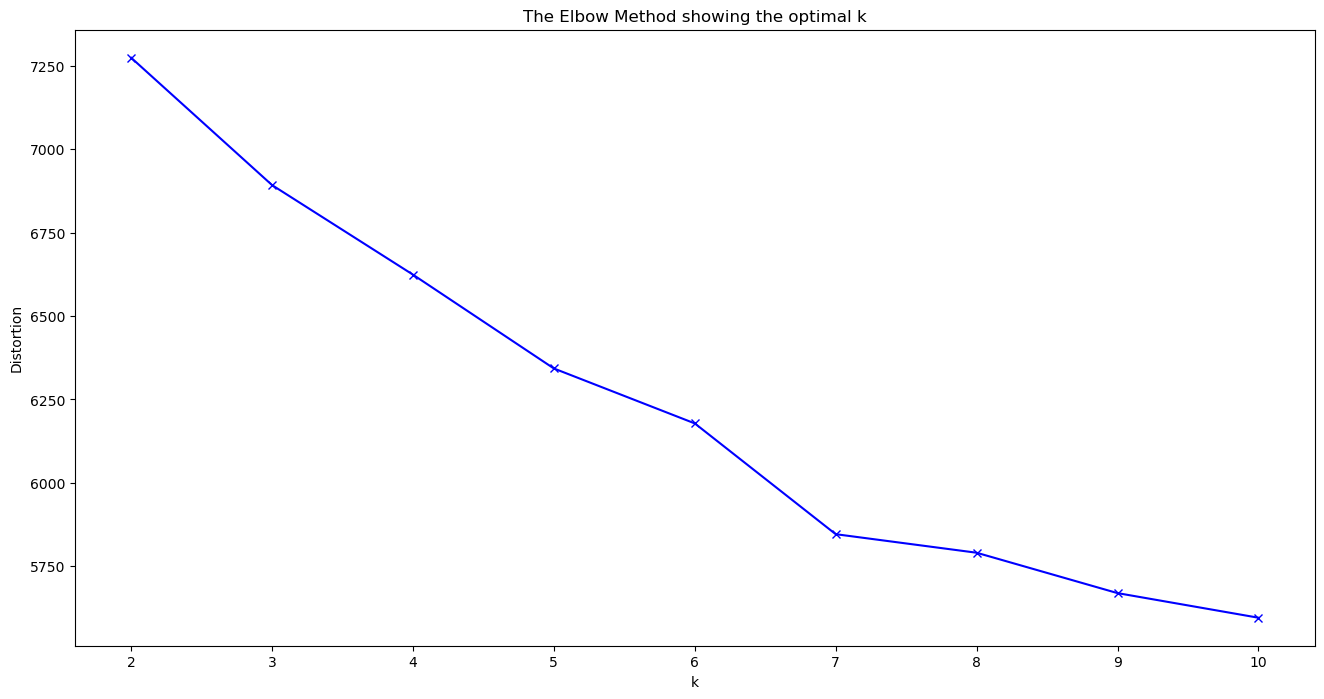

Общее время выполнения: 1611.4323194026947


In [23]:
from pyspark.mllib.clustering import KMeans
import numpy as np
import matplotlib.pyplot as plt
import time

# Преобразовать PipelinedRDD в массив NumPy
start = time.time()
data_array = df3_transformed.select('Word2VecFeatures').rdd.map(lambda x: x.Word2VecFeatures.toArray()).cache()

# Количество кластеров для исследования
K = range(2, 11)

# Сохранение искажений для каждого значения K
distortions = []

# Перебор различных значений K
for k in K:
    kmeanModel = KMeans.train(data_array, k, maxIterations=10, initializationMode="random")
    cost = kmeanModel.computeCost(data_array)
    distortions.append(cost)

plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

end = time.time()
print(f'Общее время выполнения: {end - start}')

+ Silhouette Score (метод силуета)

In [24]:
from pyspark.ml.clustering import KMeans

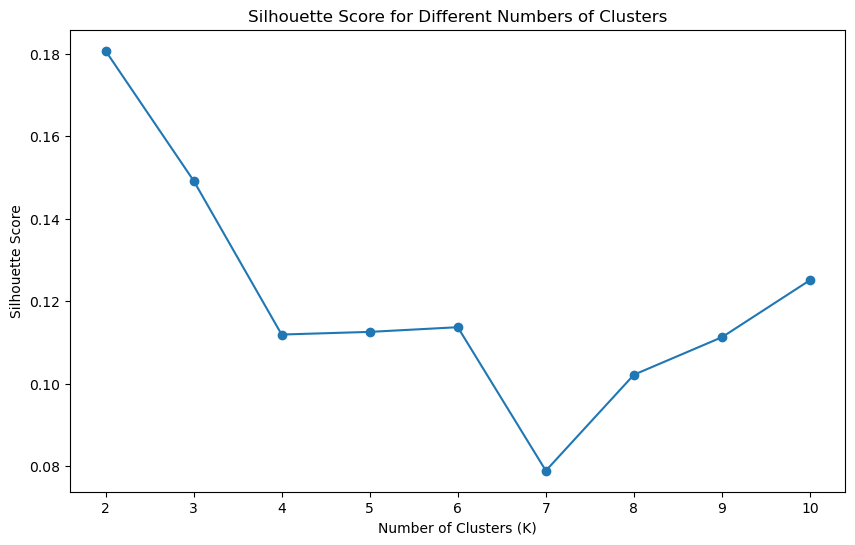

Оптимальное число кластеров (K): 2


In [25]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

# Выберите колонку с векторами
vector_col = "Word2VecFeatures"

# Создайте структурированный столбец с векторами
vec_assembler = VectorAssembler(inputCols=[vector_col], outputCol="features")
df_with_features = vec_assembler.transform(df3_transformed)

# Попробуйте разные значения для числа кластеров
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(42).setFeaturesCol("features")
    model = kmeans.fit(df_with_features)
    predictions = model.transform(df_with_features)
    
    # Оцените Silhouette Score
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

# Выбор оптимального числа кластеров
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Оптимальное число кластеров (K): {best_k}")

## Кластеризация данных

In [26]:
# Количество кластеров
k = 2

%time kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("Word2VecFeatures")
%time model_kmeans = kmeans.fit(df3_transformed)

# Добавление столбца с метками кластеров в df3_transformed
df_clustered = model_kmeans.transform(df3_transformed)

# Вывод результатов
df_clustered.select("Word2VecFeatures", "prediction").show()

CPU times: user 1.25 ms, sys: 2.72 ms, total: 3.97 ms
Wall time: 8.52 ms
CPU times: user 586 ms, sys: 305 ms, total: 891 ms
Wall time: 1h 18min 14s
+--------------------+----------+
|    Word2VecFeatures|prediction|
+--------------------+----------+
|[0.01747313140191...|         1|
|[0.03660057192513...|         0|
|[-0.2455033273149...|         0|
|[0.18082185894678...|         1|
|[0.04708396398264...|         1|
|[-0.0582585154172...|         0|
|[-0.0592526307229...|         1|
|[0.17262899130582...|         1|
|[-0.0980689395474...|         1|
|[-0.0624329893696...|         1|
|[-0.0317996684440...|         0|
|[0.22063947189599...|         1|
|[-0.0155320429631...|         1|
|[0.02013864812987...|         1|
|[-0.1852975999708...|         0|
|[0.02920356701025...|         1|
|[-0.0361287926037...|         0|
|[0.15585361172755...|         1|
|[0.01664245746703...|         1|
|[0.04984149336814...|         1|
+--------------------+----------+
only showing top 20 rows



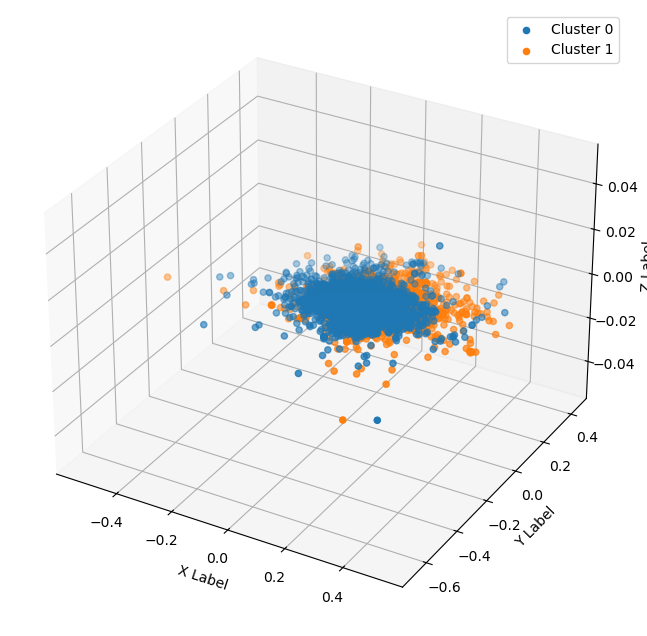

Общее время выполнения: 2425.4478216171265


In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
start = time.time()
# Извлечение данных для визуализации
features = np.array(df_clustered.select("Word2VecFeatures").rdd.map(lambda x: x.Word2VecFeatures).collect())
predictions = np.array(df_clustered.select("prediction").rdd.map(lambda x: x.prediction).collect())

# Визуализация кластеров в трехмерном пространстве
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Разделение данных по кластерам
for cluster in set(predictions):
    cluster_data = features[predictions == cluster]
    ax.scatter(cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster}')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()

plt.show()
end = time.time()

print(f'Общее время выполнения: {end - start}')

In [28]:
# Поставил 7, т.к. в методе локня 7 более явно выражено, добавил тайминги

# Количество кластеров
k = 7

%time kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("Word2VecFeatures")
%time model_kmeans = kmeans.fit(df3_transformed)

# Добавление столбца с метками кластеров в df3_transformed
df_clustered = model_kmeans.transform(df3_transformed)

# Вывод результатов
df_clustered.select("Word2VecFeatures", "prediction").show()

CPU times: user 4.38 ms, sys: 0 ns, total: 4.38 ms
Wall time: 6.58 ms
CPU times: user 408 ms, sys: 197 ms, total: 605 ms
Wall time: 58min 54s
+--------------------+----------+
|    Word2VecFeatures|prediction|
+--------------------+----------+
|[0.01747313140191...|         0|
|[0.03660057192513...|         4|
|[-0.2455033273149...|         2|
|[0.18082185894678...|         0|
|[0.04708396398264...|         0|
|[-0.0582585154172...|         5|
|[-0.0592526307229...|         4|
|[0.17262899130582...|         1|
|[-0.0980689395474...|         6|
|[-0.0624329893696...|         1|
|[-0.0317996684440...|         4|
|[0.22063947189599...|         1|
|[-0.0155320429631...|         6|
|[0.02013864812987...|         1|
|[-0.1852975999708...|         4|
|[0.02920356701025...|         6|
|[-0.0361287926037...|         4|
|[0.15585361172755...|         1|
|[0.01664245746703...|         0|
|[0.04984149336814...|         1|
+--------------------+----------+
only showing top 20 rows



/opt/conda/lib/python3.11/site-packages/mpl_toolkits/mplot3d/art3d.py:1136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/opt/conda/lib/python3.11/site-packages/mpl_toolkits/mplot3d/art3d.py:1138: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


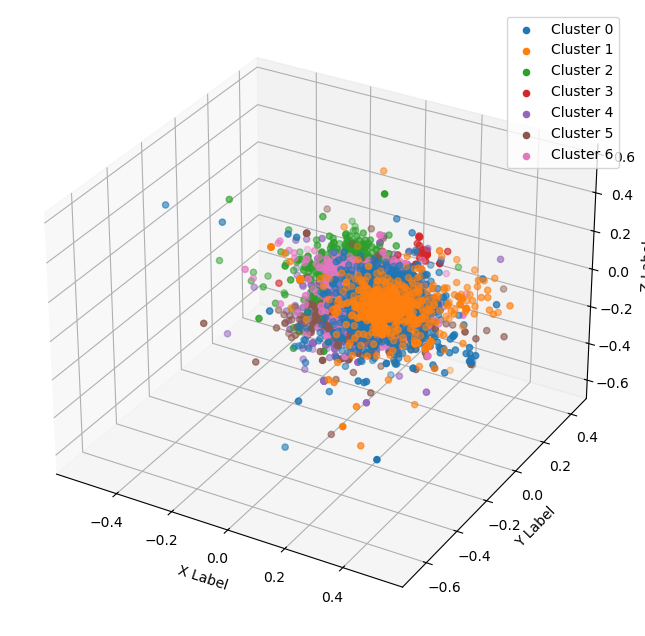

Общее время выполнения: 2403.7800233364105


In [29]:
start = time.time()
# Извлечение данных для визуализации
features = np.array(df_clustered.select("Word2VecFeatures").rdd.map(lambda x: x.Word2VecFeatures).collect())
predictions = np.array(df_clustered.select("prediction").rdd.map(lambda x: x.prediction).collect())

# Визуализация кластеров в трехмерном пространстве
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Разделение данных по кластерам
for cluster in set(predictions):
    cluster_data = features[predictions == cluster]
    ax.scatter(cluster_data[:, 1], cluster_data[:, 2], cluster_data[:, 3], \
               cluster_data[:, 4], label=f'Cluster {cluster}')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()

plt.show()
end = time.time()

print(f'Общее время выполнения: {end - start}')

## Анализ ключевых слов в тексте

In [30]:
# Для теста возьмем 9919 строк из датасета
df3=df2.limit(9919)

In [31]:
from pyspark.ml.feature import CountVectorizer
start = time.time()
# Создание модели CountVectorizer для преобразования текста в векторы частот слов
cv = CountVectorizer(inputCol="finished", outputCol="features")
model = cv.fit(df3)
data = model.transform(df3)
end = time.time()

print(f'Общее время выполнения: {end - start}')

Общее время выполнения: 1179.4938786029816


In [33]:
data.show(5)

+--------------------+--------------------+
|            finished|            features|
+--------------------+--------------------+
|[анонимный, имидж...|(107129,[4,23,34,...|
|[видионаблюдение,...|(107129,[18,21,50...|
|[главный, корпора...|(107129,[1,3,6,9,...|
|[название, назван...|(107129,[1,5,17,2...|
|[закладка, мёд, з...|(107129,[1,2,4,5,...|
+--------------------+--------------------+
only showing top 5 rows



In [34]:
from pyspark.ml.clustering import LDA
#Теперь, когда подготовка данных завершена, пришло время запускать модель. 
#Здесь я определяю количество тем и итераций и начинаю обучение.
start = time.time()
# Создание модели LDA
lda = LDA(k=5, maxIter=10)
lda_model = lda.fit(data)
result_tfidf = lda_model.transform(data)
# Выводим темы
topics = lda_model.describeTopics().collect()

for topic in topics:
    print("Topic {}: ".format(topic.topic))
    words = model.vocabulary
    for word in topic.termIndices:
        print(" - {}".format(words[word]))
end = time.time()

print(f'Общее время выполнения: {end - start}') 

Topic 0: 
 - корзина
 - смотреть
 - добавить
 - сравнение
 - избранный
 - соус
 - просмотр
 - быстрый
 - товар
 - букет
Topic 1: 
 - женский
 - мужской
 - н
 - детский
 - футболка
 - хлопок
 - так
 - п
 - далее
 - б
Topic 2: 
 - сайт
 - зеркало
 - отель
 - автовоз
 - который
 - ставка
 - регистрация
 - официальный
 - сегодня
 - игра
Topic 3: 
 - отдых
 - работа
 - сайт
 - магазин
 - ваш
 - подробный
 - компания
 - обновление
 - доставка
 - поиск
Topic 4: 
 - широта
 - долгота
 - лето
 - путешествие
 - весна
 - гб
 - осень
 - зима
 - смотреть
 - май
Общее время выполнения: 2455.368759870529


In [35]:
result_tfidf.show(5)

+--------------------+--------------------+--------------------+
|            finished|            features|   topicDistribution|
+--------------------+--------------------+--------------------+
|[анонимный, имидж...|(107129,[4,23,34,...|[0.00222892875665...|
|[видионаблюдение,...|(107129,[18,21,50...|[0.15369246258059...|
|[главный, корпора...|(107129,[1,3,6,9,...|[6.66858895846452...|
|[название, назван...|(107129,[1,5,17,2...|[1.67972903693533...|
|[закладка, мёд, з...|(107129,[1,2,4,5,...|[8.69362709883575...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



## Тематическое моделирование

In [15]:
from pyspark.sql.types import ArrayType, StringType
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [16]:
documents = df3.select("finished").rdd.flatMap(lambda x: x.finished).collect()
texts = [doc for doc in documents]

In [17]:
# Предобработка списка строк в список списков слов
processed_texts = [text.split() for text in texts]

In [18]:
dictionary = Dictionary(processed_texts)

In [19]:
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

In [20]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())

    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

    return lm_list, c_v

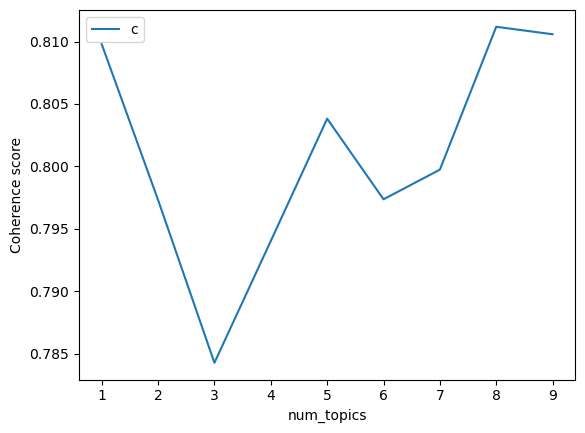

CPU times: user 20.9 s, sys: 1.34 s, total: 22.2 s
Wall time: 23.9 s


In [21]:
import matplotlib.pyplot as plt
%time lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=processed_texts, limit=10)

In [22]:
# Обучение модели LDA
num_topics = 5  # количество тем смотри по графику
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=num_topics)

# Визуализация тем
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.132869 -0.006590       1        1  22.638689
4      0.147865  0.007164       2        1  22.142663
0     -0.181305 -0.161602       3        1  18.788302
1      0.062273 -0.015379       4        1  18.244041
3     -0.161702  0.176407       5        1  18.186305, topic_info=             Term        Freq       Total Category  logprob  loglift
1693        домен  124.000000  124.000000  Default  30.0000  30.0000
211        ссылка   92.000000   92.000000  Default  29.0000  29.0000
134           ваш   76.000000   76.000000  Default  28.0000  28.0000
1724   поделиться  101.000000  101.000000  Default  27.0000  27.0000
1695  неравенство   44.000000   44.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1724   поделиться   43.264433  101.642834   Topic5  -2.8464   0.8504
1704      телефон   14.465223   29.628223   Topic5  -3.9420   0.9875
1696       польза   14.590608   43.836666   Topic5  -3.9334   0.6044
146    знакомство    8.504624   23.667283   Topic5  -4.4731   0.6810
232        брюнет    2.798734    6.891787   Topic5  -5.5846   0.8033

[225 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
922       5  0.965373          август
546       3  0.934544      автомобиль
1604      1  0.274418  альтернативный
1604      2  0.274418  альтернативный
1604      4  0.548836  альтернативный
...     ...       ...             ...
1712      3  0.937479           чётко
1434      1  0.349615         элемент
1434      2  0.699231         элемент
598       4  0.767999        являться
1713      3  0.937475            ясно

[243 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])